<a href="https://colab.research.google.com/github/akiltrebreg/ai24_ecg/blob/main/RNN_AK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Сборка pandas датасета

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

RAND = 42

In [2]:
import pandas as pd
from google.colab import drive

drive.mount('/content/gdrive')
path = '/content/gdrive/My Drive/Colab Notebooks/ecg_project/'

df = pd.read_csv(path + 'ecg_df.csv')

Mounted at /content/gdrive


In [3]:
df.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,three_kurtosis,aVR_kurtosis,aVL_kurtosis,aVF_kurtosis,V1_kurtosis,V2_kurtosis,V3_kurtosis,V4_kurtosis,V5_kurtosis,V6_kurtosis
0,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
1,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
2,E09826,53,39,-14,-46,34,12,-63,39,53,...,0.603832,4.229891,0.437643,1.515420,4.455373,8.565127,8.960794,1.992966,7.847901,9.826116
3,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336
4,E09837,-39,-156,-117,97,39,-136,-19,19,-156,...,0.236699,2.782589,1.770129,0.392972,8.797798,14.848717,12.909421,8.873570,7.821621,3.677336


In [4]:
df.columns.tolist()

['id',
 'one',
 'two',
 'three',
 'aVR',
 'aVL',
 'aVF',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'gender',
 'age',
 'labels',
 'signal',
 'disease_name',
 'short_disease_name',
 'one_spectral_entropy',
 'two_spectral_entropy',
 'three_spectral_entropy',
 'aVR_spectral_entropy',
 'aVL_spectral_entropy',
 'aVF_spectral_entropy',
 'V1_spectral_entropy',
 'V2_spectral_entropy',
 'V3_spectral_entropy',
 'V4_spectral_entropy',
 'V5_spectral_entropy',
 'V6_spectral_entropy',
 'one_spectral_variation',
 'two_spectral_variation',
 'three_spectral_variation',
 'aVR_spectral_variation',
 'aVL_spectral_variation',
 'aVF_spectral_variation',
 'V1_spectral_variation',
 'V2_spectral_variation',
 'V3_spectral_variation',
 'V4_spectral_variation',
 'V5_spectral_variation',
 'V6_spectral_variation',
 'one_mfcc',
 'two_mfcc',
 'three_mfcc',
 'aVR_mfcc',
 'aVL_mfcc',
 'aVF_mfcc',
 'V1_mfcc',
 'V2_mfcc',
 'V3_mfcc',
 'V4_mfcc',
 'V5_mfcc',
 'V6_mfcc',
 'one_spectral_decrease',
 'two_spectral_decrease',


In [5]:
df.labels.nunique()

67

In [6]:
df_raw = df.copy()

In [7]:
df_raw.shape

(23487, 139)

In [8]:
df_raw.drop_duplicates(subset=['id', 'short_disease_name'], keep='first').shape

(23478, 139)

In [9]:
df_raw[df_raw.duplicated(subset=['id', 'short_disease_name'], keep=False)][['id', 'labels']]

,id,labels
17092,E02290,427084000
17093,E02290,425623009
17094,E02290,164909002
17169,E02290,427084000
17170,E02290,425623009
17171,E02290,164909002
17174,E02288,428750005
19063,E02286,426783006
19117,E02289,164909002
19171,E02288,428750005


In [10]:
df_raw[df_raw['id'] == 'E02290'][['id', 'labels']].sort_values(by='labels')

,id,labels
17094,E02290,164909002
17171,E02290,164909002
17170,E02290,425623009
17093,E02290,425623009
17169,E02290,427084000
17092,E02290,427084000


In [11]:
df_raw[df_raw['id'] == 'E02287'][['id', 'labels']].sort_values(by='labels')

,id,labels
19189,E02287,164934002
19220,E02287,164934002
19221,E02287,251146004
19190,E02287,251146004
19219,E02287,427084000
19188,E02287,427084000


In [12]:
def pivot_disease_table(df: pd.DataFrame, id_col: str, disease_col: str):
    """
    Универсальная функция схлопывания датасета по id.

    Аргументы:
    - df: DataFrame с данными
    - id_col: Название колонки с идентификатором пациента
    - disease_col: Название колонки с заболеваниями

    Возвращает:
    - DataFrame, где каждая строка — один пациент, а болезни в виде списка one-hot encoding.
    - Список уникальных заболеваний в том порядке, в котором они соответствуют кодировке.
    """
    # Получаем список всех уникальных заболеваний в отсортированном порядке
    unique_diseases = sorted(df[disease_col].unique())

    # One-hot encoding для болезней
    df_one_hot = pd.crosstab(df[id_col], df[disease_col]).reset_index()

    # Определяем остальные колонки (кроме id и disease)
    other_cols = [col for col in df.columns if col not in {id_col, disease_col}]

    # Присоединяем остальные колонки (берём первое вхождение для каждого id)
    df_meta = df.groupby(id_col)[other_cols].first().reset_index()

    # Объединяем one-hot encoding с дополнительными колонками
    df_final = df_meta.merge(df_one_hot, on=id_col)

    # Преобразуем one-hot encoding в список
    df_final[disease_col] = df_final[unique_diseases].values.tolist()

    # Удаляем отдельные колонки заболеваний
    df_final = df_final.drop(columns=unique_diseases)

    return df_final, unique_diseases  # Возвращаем также список болезней

In [13]:
df = df.dropna()

In [14]:
df.shape

(23468, 139)

In [15]:
df = df.drop_duplicates(subset=['id', 'labels'], keep='first')

In [16]:
df.shape

(23459, 139)

In [17]:
df[df['id'] == 'E02287'][['id', 'labels']].sort_values(by='labels')

,id,labels
19189,E02287,164934002
19190,E02287,251146004
19188,E02287,427084000


In [18]:
df = df.drop(columns=['labels', 'short_disease_name'])

In [19]:
df.disease_name.value_counts()

,count
disease_name,
t wave abnormal,2304
nonspecific st t abnormality,1883
sinus rhythm,1750
sinus bradycardia,1675
prolonged qt interval,1391
...,...
ventricular bigeminy,2
supraventricular premature beats,1
acute myocardial ischemia,1


In [20]:
df.disease_name.value_counts()[:50]

,count
disease_name,
t wave abnormal,2304
nonspecific st t abnormality,1883
sinus rhythm,1750
sinus bradycardia,1675
prolonged qt interval,1391
sinus tachycardia,1260
left ventricular hypertrophy,1231
st interval abnormal,992
left axis deviation,940


In [21]:
df.disease_name.value_counts()[50:]

,count
disease_name,
complete heart block,8
myocardial infarction,7
wandering atrial pacemaker,7
s t changes,6
bradycardia,6
junctional escape,5
junctional tachycardia,4
ventricular fibrillation,3
wolff parkinson white pattern,2


In [22]:
top_50_diseases = df.disease_name.value_counts().index[:50]
df_filtered = df[df.disease_name.isin(top_50_diseases)]

In [23]:
df_filtered['disease_name']


,disease_name
0,t wave abnormal
1,left atrial enlargement
2,prolonged qt interval
3,av block
4,atrial flutter
...,...
23482,premature atrial contraction
23483,left ventricular hypertrophy
23484,sinus rhythm
23485,nonspecific intraventricular conduction disorder


In [24]:
# Вызываем функцию
df_transformed, disease_list = pivot_disease_table(df_filtered, id_col="id", disease_col="disease_name")

In [25]:
df_transformed.head(50)

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,aVR_kurtosis,aVL_kurtosis,aVF_kurtosis,V1_kurtosis,V2_kurtosis,V3_kurtosis,V4_kurtosis,V5_kurtosis,V6_kurtosis,disease_name
0,E00001,136,87,-48,-112,92,19,-39,58,87,...,18.889412,22.581295,7.270635,27.737573,8.864612,11.224089,14.399584,22.400599,25.833202,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,E00002,-29,-48,-19,39,-4,-34,9,0,-19,...,18.700376,22.227619,8.279588,27.760585,9.870266,10.459103,14.405418,23.353991,24.496420,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,E00003,24,19,-4,-21,14,7,-24,-19,-34,...,15.841014,10.381798,10.971297,24.706873,3.172721,1.463750,21.683909,23.608061,11.152247,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,E00004,19,-29,-48,4,34,-39,9,19,39,...,3.783909,7.062387,1.571121,2.125262,8.923337,16.238660,21.401044,21.116673,15.166522,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,E00005,-39,-97,-58,68,9,-78,0,-82,-73,...,1.091926,5.447872,0.311795,3.908673,9.353396,4.713335,3.238531,2.028570,2.082271,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,E00006,-19,-19,0,19,-9,-9,14,-24,-43,...,23.177349,624.038663,343.776565,19.493232,33.255766,207.199358,143.611195,42.949098,23.150398,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,E00007,-48,-29,19,39,-34,-4,39,39,-19,...,20.098062,23.787178,15.574385,20.827321,18.470819,20.056618,8.144287,23.298834,20.252758,"[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
7,E00008,117,-292,-409,87,263,-351,136,39,-87,...,3.724076,13.757864,5.509798,0.985232,13.129081,13.423707,7.666170,8.209783,1.641280,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
8,E00009,-58,-48,9,53,-34,-19,-19,-58,-82,...,7.596162,15.967702,16.500476,2.354532,9.310852,12.937555,8.181713,9.750722,10.475673,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,E00010,58,48,-9,-53,34,19,-78,29,9,...,8.035074,18.829026,7.140248,1.778802,8.490984,18.208847,14.364962,17.307506,18.874021,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [26]:
len(df_transformed.disease_name.iloc[0])

50

In [27]:
disease_list

['1st degree av block',
 '2nd degree av block',
 'accelerated junctional rhythm',
 'anterior ischemia',
 'atrial fibrillation',
 'atrial flutter',
 'atrial hypertrophy',
 'atrial pacing pattern',
 'atrial tachycardia',
 'av block',
 'bundle branch block',
 'complete right bundle branch block',
 'early repolarization',
 'incomplete left bundle branch block',
 'incomplete right bundle branch block',
 'inferior ischaemia',
 'lateral ischaemia',
 'left anterior fascicular block',
 'left atrial abnormality',
 'left atrial enlargement',
 'left axis deviation',
 'left bundle branch block',
 'left posterior fascicular block',
 'left ventricular hypertrophy',
 'low qrs voltages',
 'nonspecific intraventricular conduction disorder',
 'nonspecific st t abnormality',
 'premature atrial contraction',
 'prolonged qt interval',
 'qwave abnormal',
 'r wave abnormal',
 'right atrial abnormality',
 'right axis deviation',
 'right bundle branch block',
 'right ventricular hypertrophy',
 'sinus arrhythmia

In [28]:
len(disease_list)

50

In [29]:
# разобьем колонки с mfcc на одна колонка - одно число для удобства работы с метрикой

def split_mfcc_columns(df):

    mfcc_columns = [col for col in df.columns if 'mfcc' in col]

    for col in mfcc_columns:
        df[col] = df[col].astype(str)
        df[col] = df[col].str.strip('()').apply(lambda x: [float(i) for i in x.split(', ')])

        for i in range(len(df[col][0])):
            new_col_name = f"{col}_{i}"
            df[new_col_name] = df[col].apply(lambda x: x[i] if len(x) > i else None)

        df.drop(columns=[col], inplace=True)

    return df

In [30]:
df_end = split_mfcc_columns(df_transformed)

In [31]:
df_end.head()

,id,one,two,three,aVR,aVL,aVF,V1,V2,V3,...,V6_mfcc_2,V6_mfcc_3,V6_mfcc_4,V6_mfcc_5,V6_mfcc_6,V6_mfcc_7,V6_mfcc_8,V6_mfcc_9,V6_mfcc_10,V6_mfcc_11
0,E00001,136,87,-48,-112,92,19,-39,58,87,...,-2.260955,-49.999283,-30.767835,-71.271242,-87.562163,-62.512533,-137.021327,-206.115548,-96.285272,-120.946123
1,E00002,-29,-48,-19,39,-4,-34,9,0,-19,...,3.591314,-16.353693,-79.051264,-29.021013,-89.113628,-223.773220,-42.099348,-140.327477,-195.142066,-163.030647
2,E00003,24,19,-4,-21,14,7,-24,-19,-34,...,27.681020,93.736727,-55.728658,-269.272164,-177.249977,-77.093579,-184.398706,-229.366721,-107.847786,-173.606079
3,E00004,19,-29,-48,4,34,-39,9,19,39,...,19.630106,19.844677,-61.307162,-105.069194,-90.358914,-54.206987,-164.607119,-257.293014,-249.690065,-112.961817
4,E00005,-39,-97,-58,68,9,-78,0,-82,-73,...,55.606757,-35.645738,-94.884154,-107.153718,-37.620155,16.582211,-145.458923,-162.417971,-167.920031,-129.957256


In [32]:
df_end.shape

(10335, 269)

In [33]:
# сохраним датасет в этом состоянии
df_end.to_csv('ecg_df.csv', index=False)

In [34]:
df_end_neuro = df_end[['id', 'disease_name']].copy()

df_end_neuro.head()

,id,disease_name
0,E00001,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,E00002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,E00003,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,E00004,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,E00005,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Сборка датасета для загрузки в нейросеть

In [35]:
!pip install ecg-plot

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ecg_plot
import seaborn as sns
import math
from scipy.io import loadmat
import torch
import torchaudio
from torchaudio.transforms import Spectrogram
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split

import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Функция загрузки сигнала из .mat-файла
def load_challenge_data(filename):
    import scipy.io
    return scipy.io.loadmat(filename)['val'], None

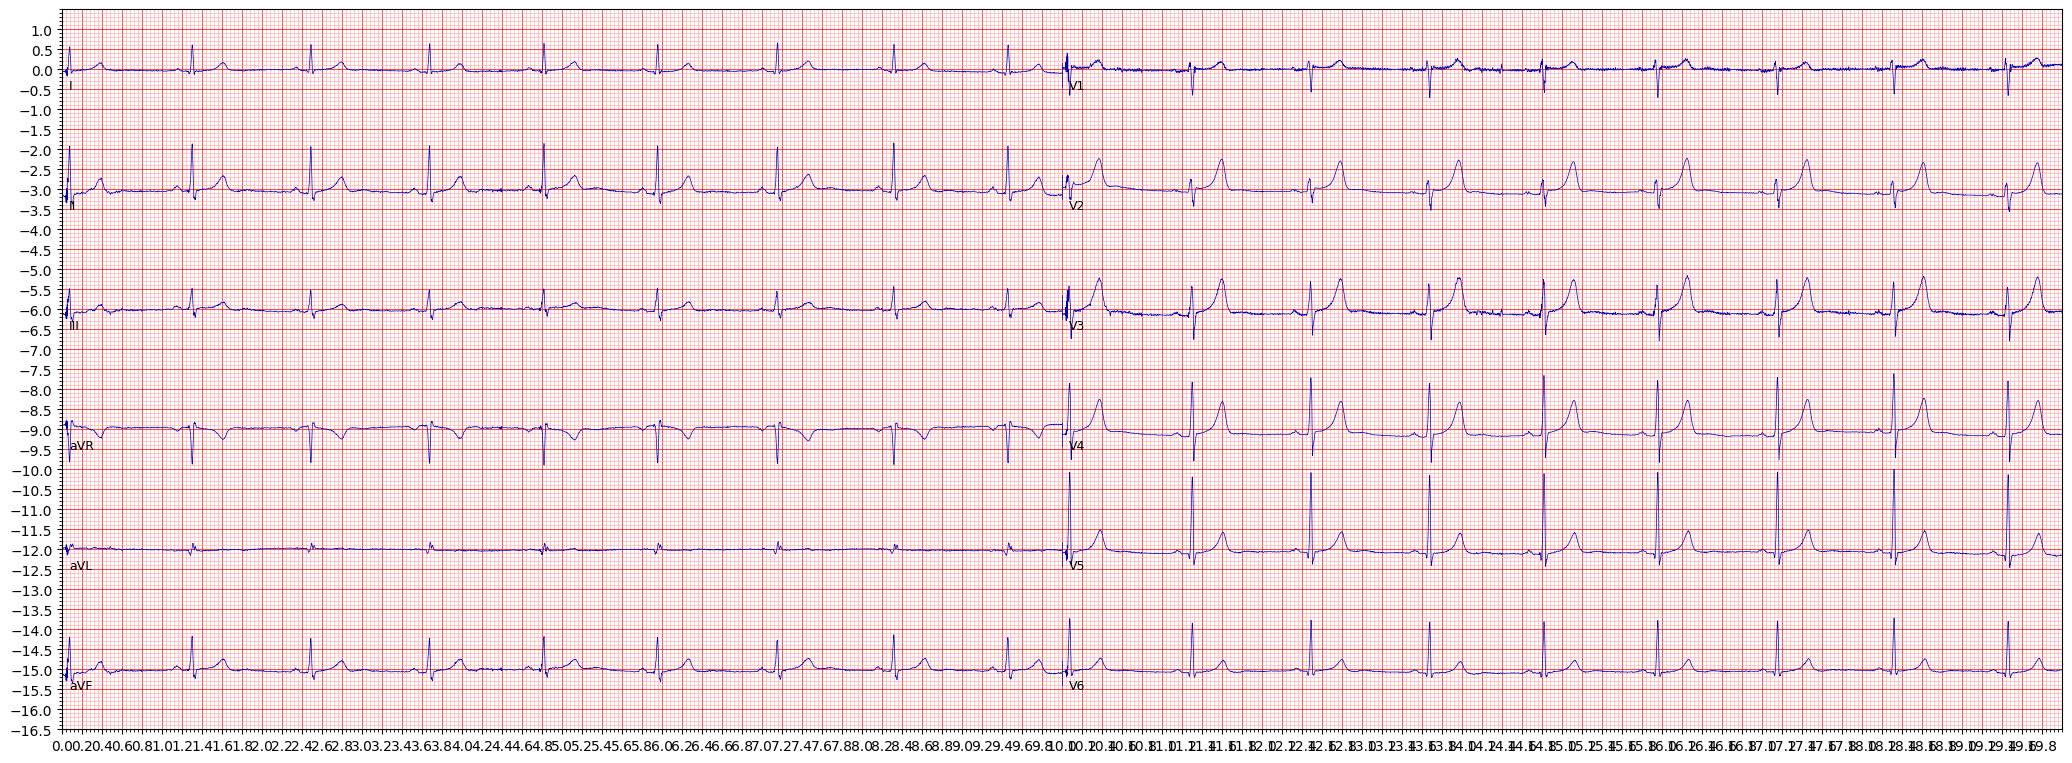

In [37]:
def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

def plot_ecg(path):
    ecg_data = load_challenge_data(path)
    ecg_plot.plot(ecg_data[0]/1000, sample_rate=500, title='')
    ecg_plot.show()


plot_ecg("/content/gdrive/My Drive/Colab Notebooks/ecg_project/Georgia/E08807.mat")

In [38]:
path = "/content/gdrive/My Drive/Colab Notebooks/ecg_project/Georgia/E08807.mat"

ecg_data = load_challenge_data("/content/gdrive/My Drive/Colab Notebooks/ecg_project/Georgia/E08807.mat")

In [39]:
ecg_data

(array([[ -63.,  -68.,  -68., ...,  -92.,  -92., -102.],
        [-170., -175., -175., ..., -141., -136., -141.],
        [-107., -107., -107., ...,  -48.,  -43.,  -39.],
        ...,
        [-122., -122., -122., ..., -131., -131., -126.],
        [ -82.,  -82.,  -82., ..., -151., -146., -146.],
        [ -58.,  -58.,  -58., ...,  -14.,   -9.,  -19.]]),
 ['E08807.mat 12 500 5000 05-May-2020 09:49:17\n',
  'E08807.mat 16+24 4880/mV 16 0 -63 -32536 0 I\n',
  'E08807.mat 16+24 4880/mV 16 0 -170 22017 0 II\n',
  'E08807.mat 16+24 4880/mV 16 0 -107 -10555 0 III\n',
  'E08807.mat 16+24 4880/mV 16 0 117 5280 0 aVR\n',
  'E08807.mat 16+24 4880/mV 16 0 21 22092 0 aVL\n',
  'E08807.mat 16+24 4880/mV 16 0 -139 -26758 0 aVF\n',
  'E08807.mat 16+24 4880/mV 16 0 48 22171 0 V1\n',
  'E08807.mat 16+24 4880/mV 16 0 53 8775 0 V2\n',
  'E08807.mat 16+24 4880/mV 16 0 -107 8001 0 V3\n',
  'E08807.mat 16+24 4880/mV 16 0 -122 243 0 V4\n',
  'E08807.mat 16+24 4880/mV 16 0 -82 -9979 0 V5\n',
  'E08807.mat 16+

In [40]:
ecg_data[0]

array([[ -63.,  -68.,  -68., ...,  -92.,  -92., -102.],
       [-170., -175., -175., ..., -141., -136., -141.],
       [-107., -107., -107., ...,  -48.,  -43.,  -39.],
       ...,
       [-122., -122., -122., ..., -131., -131., -126.],
       [ -82.,  -82.,  -82., ..., -151., -146., -146.],
       [ -58.,  -58.,  -58., ...,  -14.,   -9.,  -19.]])

In [41]:
# def mat_to_spectrogram(mat_file_path, n_fft=400, win_length=None, hop_length=None):
#     # загрузка .mat файла
#     data = load_challenge_data(mat_file_path)
#     signal = data[0]

#     # нормализуем данные
#     signal = (signal - np.mean(signal, axis=1, keepdims=True)) / \
#          np.std(signal, axis=1, keepdims=True)

#     # преобразуем в тензор (формат: [каналы, длина])
#     waveform = torch.tensor(signal, dtype=torch.float32)

#     # инициализируем трансформ
#     transform = Spectrogram(
#         n_fft=n_fft,
#         win_length=win_length,
#         hop_length=hop_length,
#         power=2.0,
#         normalized=False
#     )

#     # получаем спектрограмму для каждого канала
#     spectrogram = transform(waveform)  # shape: (12, freq_bins, time_frames)

#     return spectrogram

In [42]:
# путь к папке с .mat-файлами
mat_dir = "/content/gdrive/My Drive/Colab Notebooks/ecg_project/Georgia"

# Dataset
class SpectrogramDatasetFromMat(Dataset):
    def __init__(self, mat_dir, labels_df, n_fft=400, win_length=None, hop_length=None):
        self.mat_paths = [os.path.join(mat_dir, f) for f in os.listdir(mat_dir) if f.endswith('.mat')]

        self.labels_df = labels_df.copy()
        self.labels_df["id"] = self.labels_df["id"].astype(str).str.strip()
        self.labels_df.set_index("id", inplace=True)  # индексируем по айди

        self.n_fft = n_fft
        self.win_length = win_length
        self.hop_length = hop_length

        self.transform = Spectrogram(
            n_fft=self.n_fft,
            win_length=self.win_length,
            hop_length=hop_length,
            power=2.0,
            normalized=False
        )

    def __len__(self):
        return len(self.mat_paths)

    def __getitem__(self, idx):
        mat_file_path = self.mat_paths[idx]
        filename = os.path.basename(mat_file_path)
        ecg_id = filename.split(".")[0]  # E08807

        #print(ecg_id)

        # загрузка сигнала
        data = load_challenge_data(mat_file_path)
        signal = data[0]

        #print(signal)

        # Z-score нормализация, отдельно для каждого отведения
        signal = (signal - np.mean(signal, axis=1, keepdims=True)) / \
         np.std(signal, axis=1, keepdims=True)

        # преобразуем в тензор (формат: [каналы, длина])
        waveform = torch.tensor(signal, dtype=torch.float32)

        spectrogram = self.transform(waveform)  # [12, freq, time]

        # применим логарифмическое масштабирование (чтобы подчеркнуть низкоамплитудные компоненты)
        #spectrogram = torch.log(spectrogram + 1e-8)

        # таргет
        label_row = self.labels_df.loc[ecg_id]
        label_tensor = torch.tensor(label_row.values, dtype=torch.float32)


        return spectrogram, label_tensor

In [43]:
# Dataset
dataset = SpectrogramDatasetFromMat(mat_dir, df_end_neuro)

total_len = len(dataset)
train_len = int(0.7 * total_len)          # 70% на обучение
val_len = int(0.15 * total_len)           # 15% на валидацию
test_len = total_len - train_len - val_len  # 15% на тест

# Разделение данных
train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_len, val_len, test_len]
)

# Даталоадеры
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

# DataLoader возвращает батчи тензоров формы:
# [batch_size, 1, freq_bins, time_frames]
# Это похоже на batch x channel x height x width, как картинки


In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchaudio.transforms import Spectrogram
from sklearn.metrics import f1_score

from scipy.io import loadmat

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [45]:
def collate_fn(batch):
    spectrograms, labels = zip(*batch)

    # паддинг по time-оси до максимального в батче
    max_time = max(spec.shape[-1] for spec in spectrograms)
    padded_specs = []
    for spec in spectrograms:
        if spec.shape[-1] < max_time:
            pad_size = max_time - spec.shape[-1]
            spec = torch.nn.functional.pad(spec, (0, pad_size))
        padded_specs.append(spec)

    specs_tensor = torch.stack(padded_specs)
    labels_tensor = torch.stack(labels)
    return specs_tensor, labels_tensor


In [46]:
mat_dir = "/content/gdrive/My Drive/Colab Notebooks/ecg_project/Georgia"
df = pd.read_csv("/content/gdrive/My Drive/Colab Notebooks/ecg_project/ecg_df.csv")

pivot_df = pd.get_dummies(df[['id', 'short_disease_name']], columns=['short_disease_name']) \
             .groupby('id').max().reset_index()

dataset = SpectrogramDatasetFromMat(mat_dir, pivot_df)
num_classes = pivot_df.shape[1] - 1

# Train / Val / Test split
train_len = int(0.7 * len(dataset))
val_len = int(0.15 * len(dataset))
test_len = len(dataset) - train_len - val_len

train_ds, val_ds, test_ds = random_split(dataset, [train_len, val_len, test_len])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False, collate_fn=collate_fn)


In [47]:
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy, AUROC, Precision, Recall, F1Score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [49]:
class ECGRNN(nn.Module):
    def __init__(self, input_size=201, hidden_size=128, num_layers=2, num_classes=50, bidirectional=True):
        super(ECGRNN, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional
        )
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * (2 if bidirectional else 1), 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = torch.mean(x, dim=1)
        x = x.permute(0, 2, 1)
        out, _ = self.gru(x)
        return self.classifier(out[:, -1, :])


In [50]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


In [51]:
def validate_epoch(model, loader, device, average="weighted"):
    model.eval()
    total_loss = 0.0
    num_labels = loader.dataset[0][1].shape[0]
    criterion = nn.BCEWithLogitsLoss()

    acc_metric = Accuracy(task="multilabel", num_labels=num_labels, average=average).to(device)
    auc_metric = AUROC(task="multilabel", num_labels=num_labels, average=average).to(device)
    prec_metric = Precision(task="multilabel", num_labels=num_labels, average=average).to(device)
    rec_metric = Recall(task="multilabel", num_labels=num_labels, average=average).to(device)
    f1_metric = F1Score(task="multilabel", num_labels=num_labels, average=average).to(device)

    with torch.no_grad():
        for x, y in tqdm(loader, desc="Valid/Test", leave=False):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)

            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).int()

            acc_metric.update(preds, y.int())
            auc_metric.update(probs, y.int())
            prec_metric.update(preds, y.int())
            rec_metric.update(preds, y.int())
            f1_metric.update(preds, y.int())

    avg_loss = total_loss / len(loader.dataset)
    acc = acc_metric.compute().item()
    auc = auc_metric.compute().item()
    prec = prec_metric.compute().item()
    rec = rec_metric.compute().item()
    f1 = f1_metric.compute().item()

    return avg_loss, acc, auc, prec, rec, f1


In [52]:
def train_model(model, train_loader, val_loader, device, epochs=25, lr=1e-4, save_path="best_model.pth", average="weighted"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'acc': [], 'prec': [], 'rec': [], 'f1': [], 'auc': []}

    for epoch in range(1, epochs + 1):
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        history['train_loss'].append(train_loss)

        val_loss, val_acc, val_auc, val_prec, val_rec, val_f1 = validate_epoch(model, val_loader, device, average)
        history['val_loss'].append(val_loss)
        history['acc'].append(val_acc)
        history['auc'].append(val_auc)
        history['prec'].append(val_prec)
        history['rec'].append(val_rec)
        history['f1'].append(val_f1)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | F1: {val_f1:.4f}")

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), save_path)

    return history


In [53]:
def test_model(model, test_loader, device, checkpoint="best_model.pth", average="weighted"):
    model.load_state_dict(torch.load(checkpoint, map_location=device))
    model.to(device)

    loss, acc, auc, prec, rec, f1 = validate_epoch(model, test_loader, device, average)

    results = {
        "Loss": [loss],
        "Accuracy": [acc],
        "ROC-AUC": [auc],
        "Precision": [prec],
        "Recall": [rec],
        "F1-Score": [f1]
    }

    results_df = pd.DataFrame(results)
    print("\nTest Results Table:")
    display(results_df)
    return results_df


In [54]:
def plot_training_history(history):
    epochs_range = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(10,5))
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    for metric in ['auc', 'acc', 'prec', 'rec', 'f1']:
        plt.figure(figsize=(10,5))
        plt.plot(epochs_range, history[metric], label=metric.upper())
        plt.xlabel('Epoch')
        plt.ylabel(metric.upper())
        plt.title(f'Validation {metric.upper()}')
        plt.grid(True)
        plt.show()


Epoch 1/25 | Train Loss: 0.4445 | Val Loss: 0.1518 | F1: 0.0000


Epoch 2/25 | Train Loss: 0.1569 | Val Loss: 0.1197 | F1: 0.0000


Epoch 3/25 | Train Loss: 0.1411 | Val Loss: 0.1166 | F1: 0.0000


Epoch 4/25 | Train Loss: 0.1365 | Val Loss: 0.1154 | F1: 0.0000


Epoch 5/25 | Train Loss: 0.1325 | Val Loss: 0.1152 | F1: 0.0000


Epoch 6/25 | Train Loss: 0.1293 | Val Loss: 0.1145 | F1: 0.0000


Epoch 7/25 | Train Loss: 0.1282 | Val Loss: 0.1141 | F1: 0.0000


Epoch 8/25 | Train Loss: 0.1268 | Val Loss: 0.1139 | F1: 0.0000


Epoch 9/25 | Train Loss: 0.1243 | Val Loss: 0.1135 | F1: 0.0000


Epoch 10/25 | Train Loss: 0.1237 | Val Loss: 0.1131 | F1: 0.0000


Epoch 11/25 | Train Loss: 0.1234 | Val Loss: 0.1130 | F1: 0.0000


Epoch 12/25 | Train Loss: 0.1228 | Val Loss: 0.1128 | F1: 0.0000


Epoch 13/25 | Train Loss: 0.1212 | Val Loss: 0.1123 | F1: 0.0000


Epoch 14/25 | Train Loss: 0.1200 | Val Loss: 0.1121 | F1: 0.0000


Epoch 15/25 | Train Loss: 0.1187 | Val Loss: 0.1114 | F1: 0.0000


Epoch 16/25 | Train Loss: 0.1180 | Val Loss: 0.1111 | F1: 0.0000


Epoch 17/25 | Train Loss: 0.1157 | Val Loss: 0.1102 | F1: 0.0000


Epoch 18/25 | Train Loss: 0.1139 | Val Loss: 0.1098 | F1: 0.0000


Epoch 19/25 | Train Loss: 0.1139 | Val Loss: 0.1091 | F1: 0.0201


Epoch 20/25 | Train Loss: 0.1126 | Val Loss: 0.1087 | F1: 0.0229


Epoch 21/25 | Train Loss: 0.1106 | Val Loss: 0.1076 | F1: 0.0517


Epoch 22/25 | Train Loss: 0.1098 | Val Loss: 0.1081 | F1: 0.0529


Epoch 23/25 | Train Loss: 0.1091 | Val Loss: 0.1072 | F1: 0.0513


Epoch 24/25 | Train Loss: 0.1079 | Val Loss: 0.1058 | F1: 0.0470


Epoch 25/25 | Train Loss: 0.1066 | Val Loss: 0.1054 | F1: 0.0546


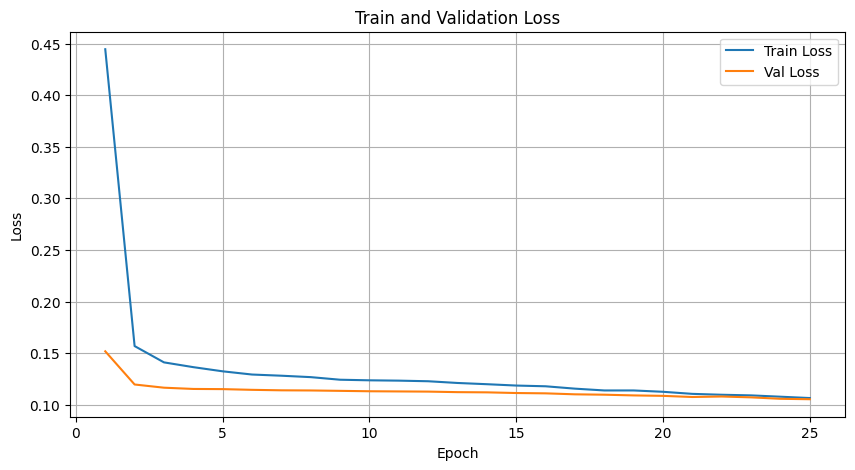

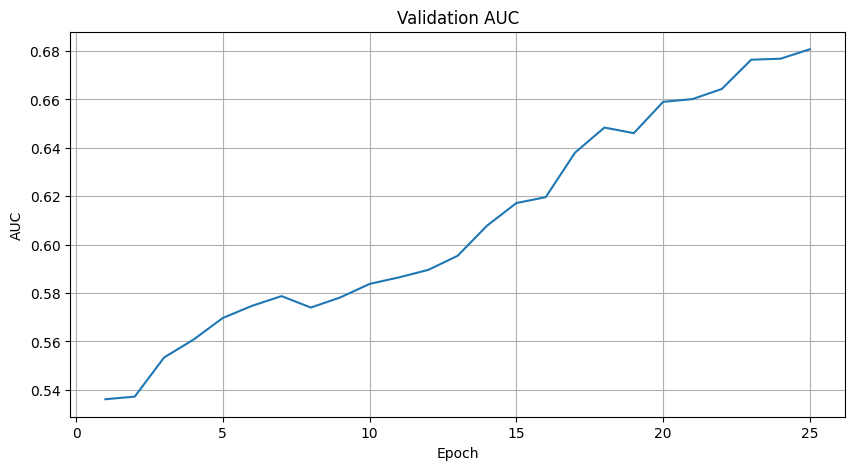

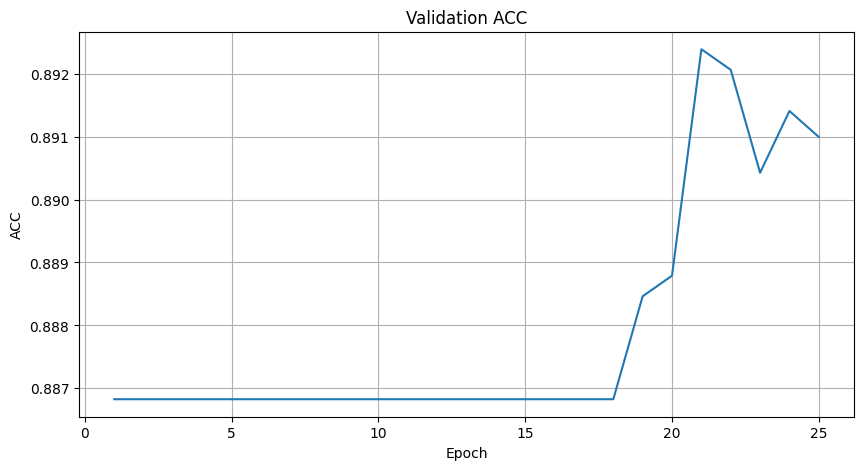

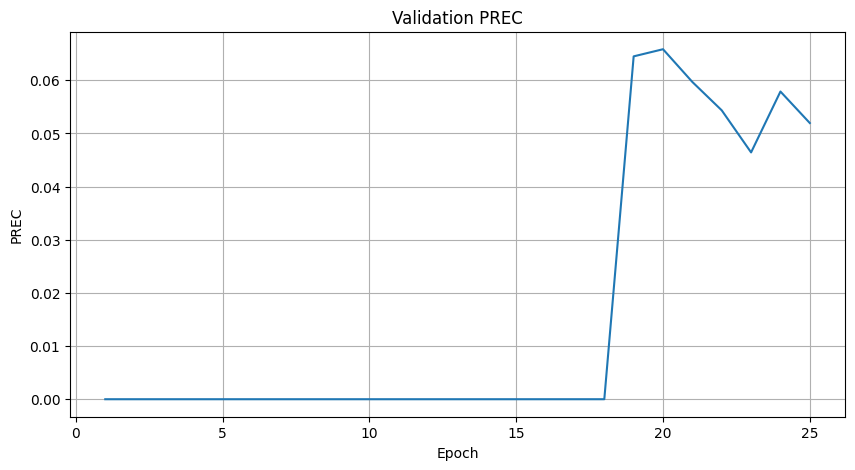

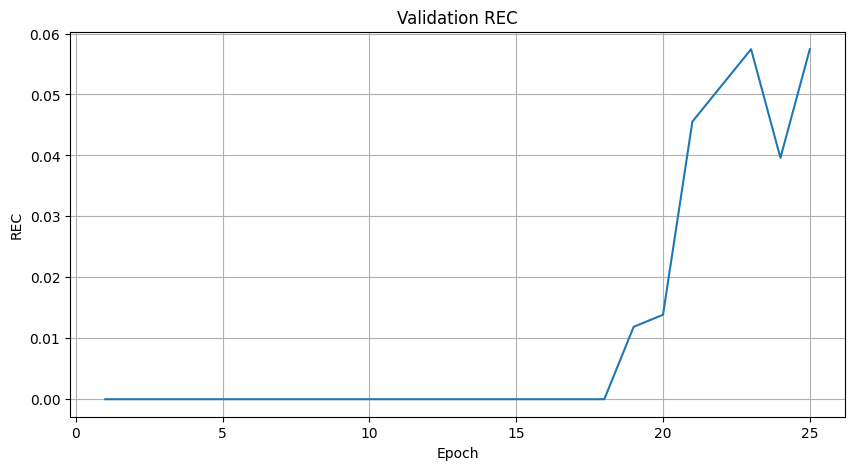

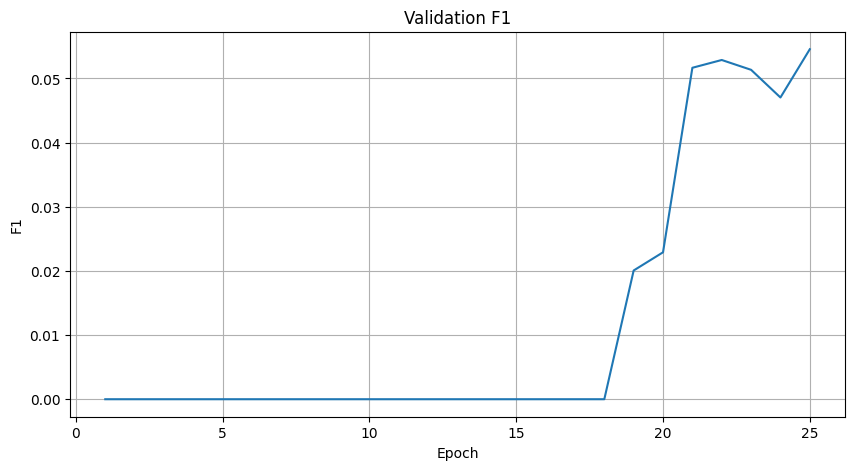


Test Results Table:


,Loss,Accuracy,ROC-AUC,Precision,Recall,F1-Score
0,0.105123,0.888535,0.696308,0.055294,0.052529,0.053876


In [55]:
# Создание модели
NUM_CLASSES = train_loader.dataset[0][1].shape[0]

model = ECGRNN(
    input_size=201,
    hidden_size=128,
    num_layers=2,
    num_classes=NUM_CLASSES,
    bidirectional=True
).to(device)


# Обучение
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=25,
    lr=1e-4,
    save_path="best_ecgrnn.pth",
    average="weighted"
)

# Построение графиков
plot_training_history(history)

# Тестирование
test_results = test_model(model, test_loader, device, checkpoint="best_ecgrnn.pth")
